<a href="https://colab.research.google.com/github/luisam19/course_optimizacion/blob/main/Taller01_optimizaci%C3%B3n_LuisaMariaZapataSaldarriaga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importación de librerías

In [1]:
#Instalemos primero los paquetes que necesitamos
!pip install -q amplpy pandas
from amplpy import AMPL, tools


In [2]:
# install pyomo and import libraries
!pip install -q pyomo
from pyomo.environ import *
from pyomo.opt import *

## instal cbc
!apt-get install -y -qq coinor-cbc
# Set the solver
solver = solvers.SolverFactory('cbc', executable='/usr/bin/cbc')


#Acceso a pandas
import pandas as pd

## Ejercicio 1

Para el ejemplo introductorio de la clase relacionado con la carga de contenedores. En el cual se busca decidir cuales contenedores usar y que ítems asignar a cada contenedor, cumpliendo con la carga máxima admisible de cada contenedor utilizado y que cada objeto se asigna exactamente a un contenedor para minimizar el número de contenedores utilizados.

|   Ítem| Peso (kg) |Ítem| Peso (kg) |Ítem| Peso (kg) |Ítem| Peso (kg) |
|-------|----|-------|----|-------|----|-------|----|
| **1** | 36 | **6** | 19 | **11** | 23 | **16** | 33 |
| **2** | 33  | **7** | 37  | **12** | 29  | **17** | 9 |
| **3** | 39	| **8** | 8	| **13** | 10	| **18** | 17	|
| **4** | 43| **9** | 29 | **14** | 22 |**19** | 30 |
| **5** | 7	| **10** | 37	| **15** | 11	| **20** | 28	|


In [3]:
from pyomo.environ import *

# Crear un modelo concreto para el Caso 1
modelo_caso1 = ConcreteModel()

# Conjuntos
modelo_caso1.I = Set(initialize=range(1, 21))
modelo_caso1.C = Set(initialize=['c1', 'c2', 'c3', 'c4', 'c5','c6','c7'])

# Parámetros
pesos = {i: [36, 33, 39, 43, 7, 19, 37, 8, 29, 37, 23, 29, 10, 22, 11, 33, 9, 17,30, 28][i-1] for i in range(1, 21)}
capacidad_maxima = 100

# Variables de decisión
modelo_caso1.X = Var(modelo_caso1.I, modelo_caso1.C, within=Binary)
modelo_caso1.Y = Var(modelo_caso1.C, within=Binary)

# Restricciones
def restriccion_recursos(modelo, c):
    return sum(modelo.X[i, c] * pesos[i] for i in modelo.I) <= capacidad_maxima * modelo.Y[c]
modelo_caso1.restriccion_recursos = Constraint(modelo_caso1.C, rule=restriccion_recursos)

def restriccion_asignacion(modelo, i):
    return sum(modelo.X[i, c] for c in modelo.C) == 1
modelo_caso1.restriccion_asignacion = Constraint(modelo_caso1.I, rule=restriccion_asignacion)

# Función objetivo
def objetivo_caso1(modelo):
    return sum(modelo.Y[c] for c in modelo.C)
modelo_caso1.objetivo = Objective(rule=objetivo_caso1, sense=minimize)

# Resolver el modelo
result_caso1 = solver.solve(modelo_caso1)

# Imprimir resultados
print("Resultados del Caso 1:")
for c in modelo_caso1.C:
    if value(modelo_caso1.Y[c]) > 0:
        print("Contenedor {}: Se utiliza".format(c))
        for i in modelo_caso1.I:
            if value(modelo_caso1.X[i, c]) > 0:
                print("  Ítem {}: Peso {}".format(i, pesos[i]))
print("Número total de contenedores utilizados:", value(modelo_caso1.objetivo))


Resultados del Caso 1:
Contenedor c1: Se utiliza
  Ítem 5: Peso 7
  Ítem 6: Peso 19
  Ítem 11: Peso 23
  Ítem 12: Peso 29
  Ítem 14: Peso 22
Contenedor c4: Se utiliza
  Ítem 7: Peso 37
  Ítem 10: Peso 37
  Ítem 17: Peso 9
  Ítem 18: Peso 17
Contenedor c5: Se utiliza
  Ítem 1: Peso 36
  Ítem 4: Peso 43
  Ítem 13: Peso 10
  Ítem 15: Peso 11
Contenedor c6: Se utiliza
  Ítem 3: Peso 39
  Ítem 16: Peso 33
  Ítem 20: Peso 28
Contenedor c7: Se utiliza
  Ítem 2: Peso 33
  Ítem 8: Peso 8
  Ítem 9: Peso 29
  Ítem 19: Peso 30
Número total de contenedores utilizados: 5.0


In [4]:
from pyomo.environ import *

# Crear un modelo concreto para el Caso 2
modelo_caso2 = ConcreteModel()

# Conjuntos
modelo_caso2.I = Set(initialize=range(1, 21))
modelo_caso2.C = Set(initialize=['c1', 'c2', 'c3', 'c4', 'c5','c6'])

# Parámetros
pesos = {i: [36, 33, 39, 43, 7, 19, 37, 8, 29, 37, 23, 29, 10, 22, 11, 33, 9, 17,30, 28][i-1] for i in range(1, 21)}
capacidad_maxima = 100

# Variables de decisión
modelo_caso2.X = Var(modelo_caso2.I, modelo_caso2.C, within=Binary)
modelo_caso2.Y = Var(modelo_caso2.C, within=Binary)
modelo_caso2.max_carga = Var(within=NonNegativeReals)

# Restricciones
def restriccion_recursos(modelo, c):
    return sum(modelo.X[i, c] * pesos[i] for i in modelo.I) <= capacidad_maxima * modelo.Y[c]
modelo_caso2.restriccion_recursos = Constraint(modelo_caso2.C, rule=restriccion_recursos)

def restriccion_asignacion(modelo, i):
    return sum(modelo.X[i, c] for c in modelo.C) == 1
modelo_caso2.restriccion_asignacion = Constraint(modelo_caso2.I, rule=restriccion_asignacion)

def max_carga_rule(modelo, c):
    return modelo.max_carga >= sum(pesos[i] * modelo.X[i, c] for i in modelo.I)
modelo_caso2.max_carga_constraint = Constraint(modelo_caso2.C, rule=max_carga_rule)

# Función objetivo auxiliar para maximizar la carga total de los contenedores
def objetivo_caso2_aux(modelo):
    return sum(pesos[i] * modelo.X[i, c] for i in modelo.I for c in modelo.C)

modelo_caso2.objetivo_aux = Objective(rule=objetivo_caso2_aux, sense=maximize)

# Función objetivo para minimizar la carga máxima entre los contenedores
def objetivo_caso2(modelo):
    return modelo.max_carga
modelo_caso2.objetivo = Objective(rule=objetivo_caso2, sense=minimize)

# Desactivar el objetivo auxiliar
modelo_caso2.objetivo_aux.deactivate()

# Resolver el modelo
result_caso2 = solver.solve(modelo_caso2)

# Imprimir resultados
print("Resultados del Caso 2:")
for c in modelo_caso2.C:
    if value(modelo_caso2.Y[c]) > 0:
        print("Contenedor {}: Se utiliza".format(c))
        for i in modelo_caso2.I:
            if value(modelo_caso2.X[i, c]) > 0:
                print("  Ítem {}: Peso {}".format(i, pesos[i]))
print("Carga máxima de un contenedor:", value(modelo_caso2.max_carga))


Resultados del Caso 2:
Contenedor c1: Se utiliza
  Ítem 2: Peso 33
  Ítem 3: Peso 39
  Ítem 15: Peso 11
Contenedor c2: Se utiliza
  Ítem 4: Peso 43
  Ítem 17: Peso 9
  Ítem 19: Peso 30
Contenedor c3: Se utiliza
  Ítem 9: Peso 29
  Ítem 14: Peso 22
  Ítem 16: Peso 33
Contenedor c4: Se utiliza
  Ítem 6: Peso 19
  Ítem 7: Peso 37
  Ítem 20: Peso 28
Contenedor c5: Se utiliza
  Ítem 1: Peso 36
  Ítem 8: Peso 8
  Ítem 11: Peso 23
  Ítem 18: Peso 17
Contenedor c6: Se utiliza
  Ítem 5: Peso 7
  Ítem 10: Peso 37
  Ítem 12: Peso 29
  Ítem 13: Peso 10
Carga máxima de un contenedor: 84.0


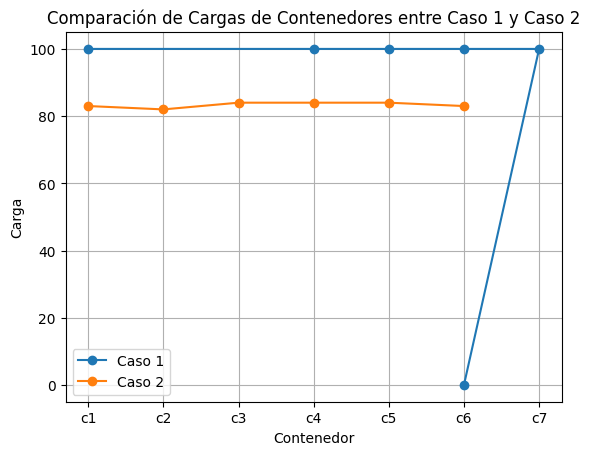

In [5]:
import matplotlib.pyplot as plt

# Obtener los contenedores y las cargas del caso 1
contenedores_caso1 =sorted([c for c in modelo_caso1.C if value(modelo_caso1.Y[c]) > 0])
cargas_caso1 = [sum(pesos[i] * value(modelo_caso1.X[i, c]) for i in modelo_caso1.I) for c in contenedores_caso1]

# Obtener los contenedores y las cargas del caso 2
contenedores_caso2 = sorted([c for c in modelo_caso2.C if value(modelo_caso2.Y[c]) > 0])
cargas_caso2 = [sum(pesos[i] * value(modelo_caso2.X[i, c]) for i in modelo_caso2.I) for c in contenedores_caso2]


import matplotlib.pyplot as plt

# Asumimos que contenedores_caso1 y contenedores_caso2 ya están definidos y ordenados correctamente

# Agregar un contenedor adicional si una lista es más corta que la otra
if len(contenedores_caso1) > len(contenedores_caso2):
    contenedores_caso2.append('c{}'.format(len(contenedores_caso2) + 1))
    cargas_caso2.append(0)  # Añadir una carga de 0 al contenedor nuevo
elif len(contenedores_caso2) > len(contenedores_caso1):
    contenedores_caso1.append('c{}'.format(len(contenedores_caso1) + 1))
    cargas_caso1.append(0)  # Añadir una carga de 0 al contenedor nuevo

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Para asegurar que el eje X muestre los contenedores en orden, convertimos los contenedores a una lista de etiquetas ordenadas
# y usamos esta lista como las etiquetas del eje X.
etiquetas_x = sorted(set(contenedores_caso1 + contenedores_caso2), key=lambda x: int(x[1:]))  # Ordenar por el número después de 'c'

# Convertir las etiquetas de los contenedores a posiciones numéricas para el eje X
posiciones_x_caso1 = [etiquetas_x.index(c) for c in contenedores_caso1]
posiciones_x_caso2 = [etiquetas_x.index(c) for c in contenedores_caso2]

# Graficar las cargas de los contenedores usando posiciones numéricas para el eje X y asignando las etiquetas correspondientes
ax.plot(posiciones_x_caso1, cargas_caso1, marker='o', label='Caso 1')
ax.plot(posiciones_x_caso2, cargas_caso2, marker='o', label='Caso 2')

# Asignar las etiquetas al eje X
ax.set_xticks(range(len(etiquetas_x)))
ax.set_xticklabels(etiquetas_x)

# Etiquetas y título
ax.set_xlabel('Contenedor')
ax.set_ylabel('Carga')
ax.set_title('Comparación de Cargas de Contenedores entre Caso 1 y Caso 2')

# Mostrar la leyenda y la cuadrícula
ax.legend()
ax.grid()

# Mostrar la gráfica
plt.show()


## Ejercicio 2

In [199]:
from amplpy import AMPL, tools
ampl = tools.ampl_notebook(
    modules=["highs", "cbc", "gurobi"], # Los optimizadores que vamos a usar
    license_uuid="default") # license to use (Aqui hay que poner su licencia :-;


In [204]:
%%ampl_eval
reset;
# Define sets
set F;  # Set of manufacturing plants
set E;  # Set of assembly plants
set R;  # Set of regions
set T;  # Set of planning periods
set S;  # Set of sub-assemblies

# Parameters
param dem{T, R};    # Demand by region and period
param cfe{F, E};   # Transportation costs of sub-assemblies
param cer{E, R};   # Transportation costs from assembly to region
param hft{F};      # Machine hours available in manufacturing plants
param hmax{E};     # Man hours available in assembly plants
param cex;      # Additional cost per man hour in overtime in assembly plants
param m{S};        # Inventory holding cost per unit for sub-assemblies
param mp;       # Inventory holding cost per unit for finished product
param req{S};        # Required production hours to manufacture a sub-assembly
param A{F,S};      # Indicates whether it can be done or not
param inise;       # Initial inventory of sub-assemblies
param inipt;       # Initial inventory of finished product
param cpt;

# Decision Variables
# Production
var X{F, T, S} integer >= 0;   # Amount of sub-assemblies manufactured in each manufacturing plant and period
var Y{E, T} integer >= 0;      # Amount of finished product shipped from each assembly plant to each region and period
var U{E, T} integer >= 0;      # Extra hours used in assembly plants
var J{E, T} integer >= 0;

# Transportation
var W{S,F,E,T}  integer>= 0;
var Z{E, R, T} integer >= 0;

# Inventory
var P{S,F,T} integer >= 0;     # Total amount of finished product stored in all assembly plants for each period
var Q{E,T} integer>= 0;     # Total amount of finished product stored in all assembly plants for each period

# #Objective Function
minimize TotalCost:
  sum {e in E, t in T} (cpt * Y[e, t]) +
  sum {e in E, t in T} (cex* U[e,t]) +
  sum {f in F, e in E, s in S, t in T} (cfe[f, e] * W[s, f, e, t]) +
  sum {e in E, r in R, t in T}(cer[e,r]*  Z[e,r,t])+
  sum {s in S, f in F, t in T} (m[s] * P[s,f,t]) +
  sum {e in E, t in T} (mp * Q[e, t]);

subject to DemandSatisfied {r in R, t in T}:
  sum {e in E} Z[e, r, t] = dem[t, r];

#Capacidad de horas de producción de sub-ensambles en las plantas de fabricación
subject to Production_Capacity{f in F, t in T}:
  sum {s in S} A[f,s]* req[s]* X[f, t, s] = hft[f];

# subject to CalculateOvertime{e in E, t in T}:
#   U[e, t] >= max(0, 2 * Y[e, t] - hmax[e]);

subject to balance {f in F, t in T,s in S}:
  X[f,t,s] = sum{e in E }W[s,f,e,t];

# subject to Subassembly_Proportion_SA {e in E, t in T}:
#   Y[e,t] <= sum {f in F} W['SA',f,e,t];

# subject to Subassembly_Proportion_SB {e in E, t in T}:
#   Y[e,t] <= sum {f in F} W['SB',f,e,t];

# subject to Subassembly_Proportion_SC {e in E, t in T}:
#   2*Y[e,t] <= W['SC','f3',e,t];

subject to y_equation{e in E, t in T}:
  #Y[e,t]=sum {f in F} X[f,t,'SA']+sum {f in F}X[f,t,'SB']+2*X['f3',t,'SC'];
  Y[e,t]=sum {f in F} W['SA',f,e,t]+sum {f in F}W['SB',f,e,t]+2*W['SC','f3',e,t];

# # Ecuación de balance de inventario de los sub-ensambles en cada planta de fabricación en cada periodo
subject to Subassembly_Inventory_Balance {s in S, f in F, t in T : t>2}:
  P[s,f,t] = P[s,f,t-1] + X[f,t,s] - sum {e in E} W[s,f,e,t];

subject to Subassembly_Inventory_Balance_init {s in S, f in F}:
  P[s,f,1] =inise + X[f,1,s] - sum {e in E} W[s,f,e,1];

subject to Finished_Product_Inventory_Balance {e in E, t in T : t > 2}:
  Q[e,t] = Q[e,t-1] + Y[e,t] - sum {r in R} Z[e, r, t];

subject to Finished_Product_Inventory_Balance_init {e in E}:
  Q[e,1] = inipt + Y[e,1] - sum {r in R} Z[e, r, 1];

subject to Assembly_Plant_Capacity {e in E, t in T}:
  2*Y[e, t]=hmax[e]+U[e, t];

In [205]:
# Definir conjuntos
ampl.set['F'] = ['f1', 'f2', 'f3']
ampl.set['E'] = ['e1', 'e2']
ampl.set['S'] = ['SA', 'SB', 'SC']
ampl.set['R'] = ['r1', 'r2', 'r3', 'r4']
ampl.set['T'] = [1, 2, 3]

# Tabla 1: Demanda por región y período
demanda_data = {
    (1, 'r1'): 1000, (1, 'r2'): 1500, (1, 'r3'): 800, (1, 'r4'): 2000,
    (2, 'r1'): 1200, (2, 'r2'): 1500, (2, 'r3'): 800, (2, 'r4'): 2500,
    (3, 'r1'): 1350, (3, 'r2'): 1750, (3, 'r3'): 1000, (3, 'r4'): 3000
}
ampl.param['dem'] = demanda_data

# Tabla 2: Costos de transporte de sub-ensambles
cfe_data = {
    ('f1', 'e1'): 1.80, ('f1', 'e2'): 2.20,
    ('f2', 'e1'): 2.90, ('f2', 'e2'): 0.60,
    ('f3', 'e1'): 1.50, ('f3', 'e2'): 2.25
}
ampl.param['cfe'] = cfe_data

# Tabla 3: Costos de transporte de ensamble a región
cer_data = {
    ('e1', 'r1'): 1.10, ('e1', 'r2'): 2.15, ('e1', 'r3'): 5.40, ('e1', 'r4'): 6.10,
    ('e2', 'r1'): 7.15, ('e2', 'r2'): 6.70, ('e2', 'r3'): 4.50, ('e2', 'r4'): 2.15
}
ampl.param['cer'] = cer_data
# Costo adicional por hora hombre en tiempo extra en plantas de ensamble
ampl.param['cex'] = 62.5

# Tabla 4: Horas máquina disponibles en plantas de fabricación
# hft_data = {('f1',1): 15000,('f1',2): 15000,('f1',3): 15000,
#             ('f2',1): 42000,('f2',2): 42000,('f2',3): 42000,
#             ('f3',1): 25000,('f3',2): 25000,('f3',3): 25000,
#              }
hft_data = {'f1':15000,'f2':42000,'f3':25000}
ampl.param['hft'] = hft_data

# Tabla 5: Horas hombre disponibles en plantas de ensamble
# hmax_data = {('e1',1): 5000,('e1',2): 5000,('e1',3): 5000,
#              ('e2',1): 6000,('e2',2): 6000,('e2',3): 6000,
#              }
hmax_data={'e1':5000,'e2':6000}
ampl.param['hmax'] = hmax_data

# Tabla 6: Costo de mantener inventario por unidad para subensambles
m_data = {'SA': 1.20, 'SB': 0.90, 'SC': 1.50}
ampl.param['m'] = m_data
ampl.param['mp'] = 7.40

# Tabla 7: Horas de producción requeridas para fabricar un sub-ensambles
r_data = {'SA': 3, 'SB': 4.5, 'SC': 2}
ampl.param['req'] = r_data

ampl.param['cpt'] = 50

ampl.param['inipt']=0
ampl.param['inise']=0

#
# Definición del parámetro A usando .setValues()
a_data = {
    ('f1', 'SA'): 1, ('f2', 'SA'): 1, ('f3', 'SA'): 1,
    ('f1', 'SB'): 1, ('f2', 'SB'): 1, ('f3', 'SB'): 1,
    ('f1', 'SC'): 0, ('f2', 'SC'): 0, ('f3', 'SC'): 1,
}
ampl.param['A'].setValues(a_data)
# Resolver el modelo
ampl.option["solver"] = "highs"
ampl.solve()

# Mostrar resultados
print(ampl.getObjective('TotalCost').value())

HiGHS 1.7.0: HiGHS 1.7.0: optimal solution; objective 7786428.4
51 simplex iterations
1 branching nodes
7786428.3999999985


************************************************** PRODUCCIÓN ************************************************** 



Xf,t,s : Cantidad de sub-ensambles s∈ S se fabricado en la planta  f e ∈ F durante el periodo t ∈ T.
--------------------------------------------------------------------------------------------------------------
                      X.val    X*req
index0 index1 index2                
f1     1      SA          2      6.0
              SB       3332  14994.0
       2      SA          2      6.0
              SB       3332  14994.0
       3      SA          2      6.0
              SB       3332  14994.0
f2     1      SA          2      6.0
              SB       9332  41994.0
       2      SA          2      6.0
              SB       9332  41994.0
       3      SA          2      6.0
              SB       9332  41994.0
f3     1      SA          1      3.0
              SB       5554  24993.0
              SC          2      4.0
       2      SA          1      3.0
     

<ipython-input-206-9e08c0459e72>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_values_non_zero['X*req'] = x_values_non_zero.apply(lambda row: row['X.val'] * req_df.at[row.name[2], 'req'], axis=1)


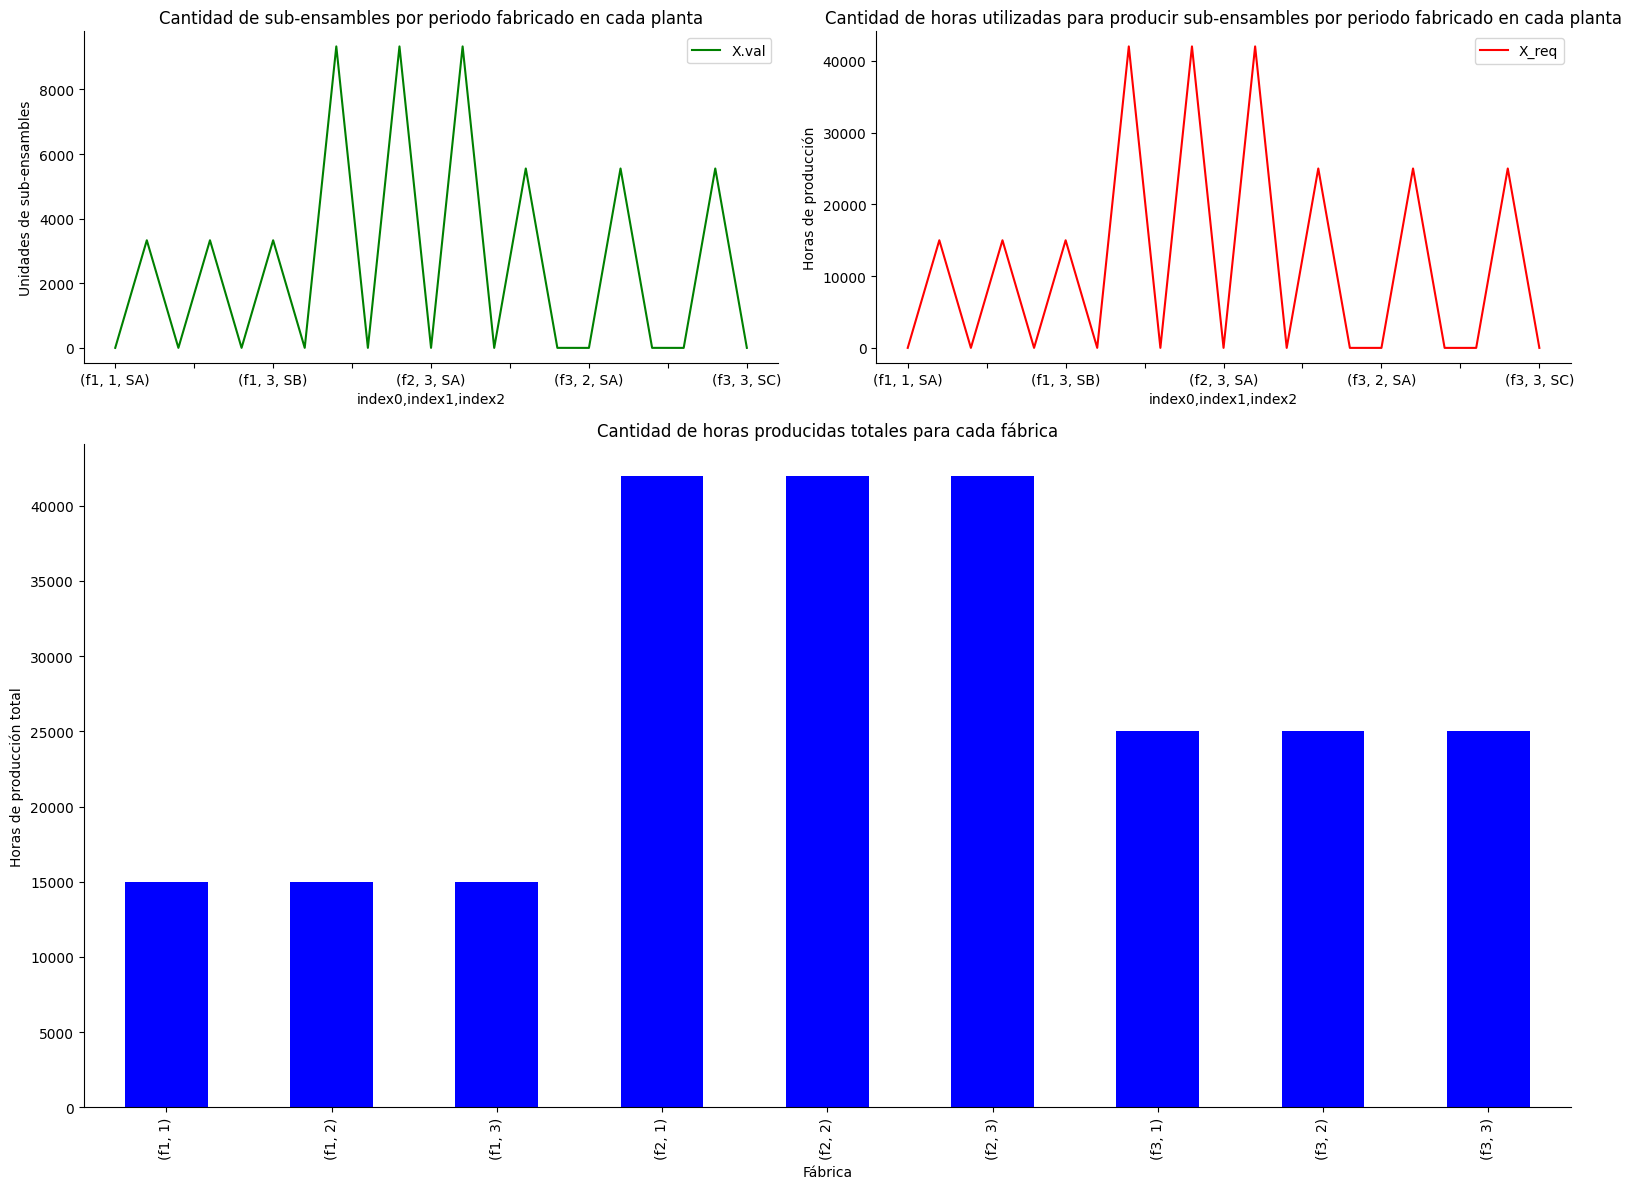

In [206]:
print('*'*50,'PRODUCCIÓN','*'*50,'\n\n\n')
print('Xf,t,s : Cantidad de sub-ensambles s∈ S se fabricado en la planta  f e ∈ F durante el periodo t ∈ T.')
print('-'*110)
# Obtener los valores de la variable X
x_values_df = ampl.getVariable('X').getValues().toPandas()
req_df=ampl.getParameter('req').getValues().toPandas()
x_values_non_zero = x_values_df[x_values_df['X.val'] != 0]
x_values_non_zero['X*req'] = x_values_non_zero.apply(lambda row: row['X.val'] * req_df.at[row.name[2], 'req'], axis=1)
print(x_values_non_zero,'\n')
sum_by_f_period = x_values_non_zero.reset_index().groupby(['index0', 'index1'])['X*req'].sum()
print('Cantidad de horas producidas totales para cada fabrica')
print('-'*110)
print(sum_by_f_period)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Creando la figura y la especificación de la grilla
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2])  # Altura de la segunda fila doble que la primera

# Creando los subplots
ax1 = plt.subplot(gs[0, 0])  # Primera fila, primera columna
ax2 = plt.subplot(gs[0, 1])  # Primera fila, segunda columna
ax3 = plt.subplot(gs[1, :])  # Segunda fila, abarcando todas las columnas

# Primer subplot con 'X.val'
x_values_non_zero['X.val'].plot(kind='line', ax=ax1,color='g')
ax1.set_title('Cantidad de sub-ensambles por periodo fabricado en cada planta')
ax1.set_ylabel('Unidades de sub-ensambles')
ax1.legend(['X.val'])
ax1.spines[['top', 'right']].set_visible(False)

# Segundo subplot con 'X_req'
x_values_non_zero['X*req'].plot(kind='line', ax=ax2,color='r')
ax2.set_title('Cantidad de horas utilizadas para producir sub-ensambles por periodo fabricado en cada planta')
ax2.set_ylabel('Horas de producción')
ax2.legend(['X_req'])
ax2.spines[['top', 'right']].set_visible(False)

# Tercer subplot con 'sum_by_f_period'
sum_by_f_period.plot(kind='bar', ax=ax3,color='b')
ax3.set_title('Cantidad de horas producidas totales para cada fábrica')
ax3.set_ylabel('Horas de producción total')
ax3.set_xlabel('Fábrica')
ax3.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

Ye,t : Cantidad de producto terminado ensamblado  en  la planta de ensamble e e ∈ E durante el periodo t ∈ T.
--------------------------------------------------------------------------------------------------------------
               Y.val
index0 index1       
e1     1        8893
       2        8893
       3        8893
e2     1        9334
       2        9334
       3        9334 



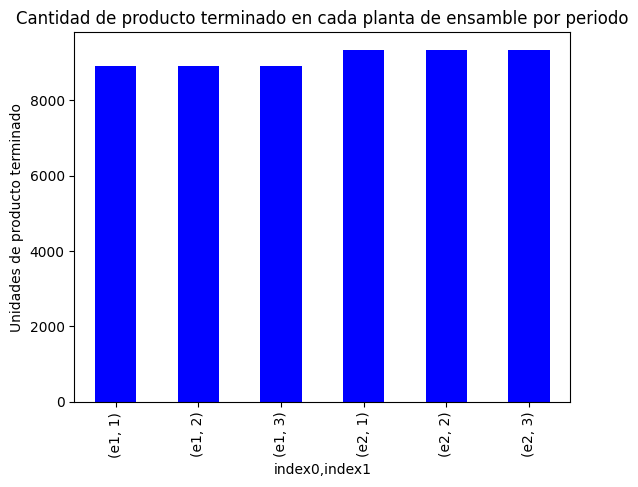

Ue,t :La cantidad de horas extra en la planta de ensamble e ∈ E durante el tiempo t ∈ T
--------------------------------------------------------------------------------------------------------------
               U.val
index0 index1       
e1     1       12786
       2       12786
       3       12786
e2     1       12668
       2       12668
       3       12668


In [207]:
print('Ye,t : Cantidad de producto terminado ensamblado  en  la planta de ensamble e e ∈ E durante el periodo t ∈ T.')
print('-'*110)
y_values_df = ampl.getVariable('Y').getValues().toPandas()
y_values_non_zero = y_values_df[y_values_df['Y.val'] != 0]
# y_values_non_zero['Y*h']=y_values_non_zero['Y.val']*2
print(y_values_non_zero,'\n')
hmax=ampl.getParameter('hmax').getValues().toPandas()

y_values_non_zero['Y.val'].plot(kind='bar',color='b',ylabel='Unidades de producto terminado', title='Cantidad de producto terminado en cada planta de ensamble por periodo')
plt.show()

print('Ue,t :La cantidad de horas extra en la planta de ensamble e ∈ E durante el tiempo t ∈ T')
print('-'*110)
u_values_df = ampl.getVariable('U').getValues().toPandas()
u_values_non_zero = u_values_df[u_values_df['U.val'] != 0]
print(u_values_non_zero)


In [208]:
# print('*'*50,'TRANSPORTE','*'*50,'\n\n\n')
print('Ws,f,e,t: Cantidad de sub-ensambles s ∈ S enviado desde la planta de f  ∈ F a la panta de ensamble e  ∈ E durante el período t ∈ T.')
print('-'*110)
w_values_df = ampl.getVariable('W').getValues().toPandas()
w_values_non_zero = w_values_df[w_values_df['W.val'] != 0]
print(w_values_non_zero,'\n')

print('Ze,r,t : Cantidad de producto terminado enviado desde la planta  e ∈ E a la región r ∈ R durante el periodo t ∈ T.')
print('-'*110)
z_values_df = ampl.getVariable('Z').getValues().toPandas()
z_values_non_zero = z_values_df[z_values_df['Z.val'] != 0]
print(z_values_non_zero,'\n')

Ws,f,e,t: Cantidad de sub-ensambles s ∈ S enviado desde la planta de f  ∈ F a la panta de ensamble e  ∈ E durante el período t ∈ T.
--------------------------------------------------------------------------------------------------------------
                             W.val
index0 index1 index2 index3       
SA     f1     e1     1           2
                     2           2
                     3           2
       f2     e2     1           2
                     2           2
                     3           2
       f3     e1     1           1
                     2           1
                     3           1
SB     f1     e1     1        3332
                     2        3332
                     3        3332
       f2     e2     1        9332
                     2        9332
                     3        9332
       f3     e1     1        5554
                     2        5554
                     3        5554
SC     f3     e1     1           2
                     2

In [209]:
print('INVENTARIO')
print('Ps,f,t : Cantidad total de sub-ensambles s ∈ S almacenado en la planta de sub-ensambles f ∈ F en el periodo t. ')
p_values_df = ampl.getVariable('P').getValues().toPandas()
p_values_non_zero = p_values_df[p_values_df['P.val'] != 0]
print(p_values_non_zero,'\n')

print('Qe,t : Cantidad total de producto terminado almacenado en la planta de ensamble e ∈ E en el periodo t. ')
q_values_df = ampl.getVariable('Q').getValues().toPandas()
q_values_non_zero = q_values_df[q_values_df['Q.val'] != 0]
print(q_values_non_zero,'\n')


INVENTARIO
Ps,f,t : Cantidad total de sub-ensambles s ∈ S almacenado en la planta de sub-ensambles f ∈ F en el periodo t. 
Empty DataFrame
Columns: [P.val]
Index: [] 

Qe,t : Cantidad total de producto terminado almacenado en la planta de ensamble e ∈ E en el periodo t. 
               Q.val
index0 index1       
e1     1        6393
       3        5793
e2     1        6534
       3        5334 



## Ejercicio 3

El Instituto de Cancerología de una prestigiosa clínica colombiana le ha contratado como consultor para que desarrolle un sistema de apoyo a las decisiones con el cual los médicos puedan diseñar los tratamientos de radioterapia de sus pacientes.  “La Radioterapia es un tipo de tratamiento oncológico que utiliza las radiaciones para eliminar las células tumorales, (generalmente cancerosas), en la parte del organismo donde se apliquen. La radiación utilizada puede ser de rayos gamma, rayos X o electrones. La radioterapia actúa sobre el tumor, destruyendo las células malignas, para impedir que crezcan y se reproduzcan. En este tipo de tratamiento, los pacientes acuden diariamente de forma ambulatoria por un período de tiempo variable, dependiendo de la enfermedad que se esté tratando.


Para eliminar un tumor es necesario irradiar todas sus partes procurando no afectar tejido sano (en color blanco en la Figura 2), sin embargo, algunas veces es inevitable. El tratamiento con radioterapia es costoso, tiene una alta demanda y es incómodo para los pacientes, lo cual hace atractivos los tratamientos que toman poco tiempo.

En este caso, el equipo utilizado permite hacer dos tipos diferentes de irradiaciones, la primera (Figura 1-T1) tiene un rayo concentrado de cubrimiento pequeño mientras que la segunda (Figura 1-T2) es capaz de irradiar áreas mayores.  La precisión de una irradiación T1 hace que su preparación y ejecución tome el doble del tiempo que para una irradiación T2.  Asuma que las irradiaciones T2 toman una unidad de tiempo.

Cuando se planea el tratamiento es necesario que los médicos tengan varias alternativas para escoger, analizando la cantidad de tejido sano irradiado y la duración del tratamiento.
Para probar sus prototipos del sistema los médicos le han entregado la imagen de un tumor bastante raro y difícil de tratar (Figura 2), para el cual usted debe diseñar tratamientos que minimicen el tejido sano irradiado. En particular se quieren tratamiento que duren como máximo 15 o 20 unidades de tiempo.

Usted ha decidido abordar esta situación utilizando sus conocimientos de optimización. Para lo cual usted deberá: formular un modelo de optimización general que describa la situación, e implementar dicho modelo en un software de optimización y probar su método utilizando el tumor de la Figura 2.


**Conteo de celdas sanas irradiadas con t1**


| C  | Sana | C  | Sana | C  | Sana | C  | Sana | C  | Sana | C  | Sana | C  | Sana | C  | Sana |
|----|------|----|------|----|------|----|------|----|------|----|------|----|------|----|------|
| 1  | 1    | 2  | 0    | 3  | 1    | 4  | 1    | 5  | 1    | 6  | 0    | 7  | 1    | 8  | 1    |
| 9  | 1    | 10 | 0    | 11 | 0    | 12 | 0    | 13 | 1    | 14 | 0    | 15 | 1    | 16 | 0    |
| 17 | 1    | 18 | 1    | 19 | 1    | 20 | 0    | 21 | 1    | 22 | 0    | 23 | 0    | 24 | 1    |
| 25 | 1    | 26 | 1    | 27 | 0    | 28 | 0    | 29 | 0    | 30 | 0    | 31 | 1    | 32 | 1    |
| 33 | 1    | 34 | 1    | 35 | 1    | 36 | 0    | 37 | 0    | 38 | 1    | 39 | 1    | 40 | 1    |
| 41 | 1    | 42 | 1    | 43 | 1    | 44 | 1    | 45 | 0    | 46 | 0    | 47 | 0    | 48 | 1    |
| 49 | 1    | 50 | 1    | 51 | 1    | 52 | 1    | 53 | 0    | 54 | 1    | 55 | 0    | 56 | 0    |
| 57 | 1    | 58 | 1    | 59 | 1    | 60 | 1    | 61 | 1    | 62 | 1    | 63 | 1    | 64 | 1    |


**Conteo de celdas sanas irradiadas con t2**

| C  | Sana | C  | Sana | C  | Sana | C  | Sana | C  | Sana | C  | Sana | C  | Sana | C  | Sana |
|----|------|----|------|----|------|----|------|----|------|----|------|----|------|----|------|
| 1  | 2    | 2  | 1    | 3  | 2    | 4  | 3    | 5  | 2    | 6  | 2    | 7  | 3    | 8  | 0    |
| 9  | 3    | 10 | 2    | 11 | 1    | 12 | 2    | 13 | 2    | 14 | 1    | 15 | 2    | 16 | 0    |
| 17 | 4    | 18 | 3    | 19 | 1    | 20 | 1    | 21 | 1    | 22 | 1    | 23 | 3    | 24 | 0    |
| 25 | 4    | 26 | 3    | 27 | 1    | 28 | 0    | 29 | 1    | 30 | 3    | 31 | 4    | 32 | 0    |
| 33 | 4    | 34 | 4    | 35 | 3    | 36 | 1    | 37 | 1    | 38 | 2    | 39 | 3    | 40 | 0    |
| 41 | 4    | 42 | 4    | 43 | 4    | 44 | 2    | 45 | 1    | 46 | 1    | 47 | 1    | 48 | 0    |
| 49 | 4    | 50 | 4    | 51 | 4    | 52 | 3    | 53 | 3    | 54 | 3    | 55 | 2    | 56 | 0    |
| 57 | 0    | 58 | 0    | 59 | 0    | 60 | 0    | 61 | 0    | 62 | 0    | 63 | 0    | 64 | 0    |




In [ ]:
# install pyomo and import libraries
!pip install -q pyomo
from pyomo.environ import *
from pyomo.opt import *
from pyomo.opt import SolverFactory, SolverManagerFactory
import os

# Establecer NEOS  como servicio para el solucionador
solver_manager = SolverManagerFactory('neos')
# Una dirección valida para ejecutar NEOS
os.environ['NEOS_EMAIL'] = 'luisa.zapatas@udea.edu.co' #Ponga su dirección de correo para una ejecución y visualización correcta de los resultados


In [ ]:
from pyomo.environ import *
from pyomo.opt import SolverFactory, SolverManagerFactory
import matplotlib.pyplot as plt

def resolver_modelo(umax):
    model = ConcreteModel()
    C= list(range(1,65))
    model.T = Set(initialize=['t1', 't2'])  # Tipos de irradiación
    model.C = Set(initialize=C)  # Celdas

    # Variables de Decisión
    model.X = Var(model.T, model.C, within=Binary)

    # Parámetros
    a = {1:0,2:1,3:0,4:0,5:0,6:1,7:0,8:0,
        9:0,10:1,11:1,12:1,13:0,14:1,15:0,16:1,
        17:0,18:0,19:0,20:1,21:0,22:1,23:1,24:0,
        25:0,26:0,27:1,28:1,29:1,30:1,31:0,32:0,
        33:0,34:0,35:0,36:1,37:1,38:0,39:0,40:0,
        41:0,42:0,43:0,44:0,45:1,46:1,47:1, 48:0,
        49:0,50:0,51:0,52:0,53:1,54:0,55:1,56:1,
        57:0,58:0,59:0,60:0,61:0,62:0,63:0,64:0
    }  # Presencia o ausencia de área afectada en la celda

    tipo2 = {
        2: [1,2],
        6:[5,6],
        10:[1,2,9,10],
        11:[2,3,10,11],
        12:[3,4,11,12],
        14:[5,6,13,14],
        16:[7,15],
        20:[11,12,19,20],
        22:[13,14,21,22],
        23:[14,15,22,23],
        27:[18,19,26,27],
        28:[19,20,27,28],
        29:[20,21,28,29],
        30:[21,22,29,30],
        36:[27,28,35,36],
        37:[28,29,36,37],
        45:[36,37,44,45],
        46:[37,38,45,46],
        47:[38,39,46,47],
        53:[44,45,52,53],
        55:[46,47,54,55],
        56:[47,55],
    }

    us = {'t1': 2, 't2': 1}  # Unidad de tiempo del tipo de irradiación
    umax1 = 20  # Unidades de tiempo máximo de irradiación
    umax2 = 15

    sanot1 = {
        1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1,
        9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 1, 16: 0,
        17: 1, 18: 1, 19: 1, 20: 0, 21: 1, 22: 0, 23: 0, 24: 1,
        25: 1, 26: 1, 27: 0, 28: 0, 29: 0, 30: 0, 31: 1, 32: 1,
        33: 1, 34: 1, 35: 1, 36: 0, 37: 0, 38: 1, 39: 1, 40: 1,
        41: 1, 42: 1, 43: 1, 44: 1, 45: 0, 46: 0, 47: 0, 48: 1,
        49: 1, 50: 1, 51: 1, 52: 1, 53: 0, 54: 1, 55: 0, 56: 0,
        57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1
    }

    sanot2 = {
        1: 2, 2: 1, 3: 2, 4: 3, 5: 2, 6: 2, 7: 3, 8: 0,
        9: 3, 10: 2, 11: 1, 12: 2, 13: 2, 14: 1, 15: 2, 16: 0,
        17: 4, 18: 3, 19: 1, 20: 1, 21: 1, 22: 1, 23: 3, 24: 0,
        25: 4, 26: 3, 27: 1, 28: 0, 29: 1, 30: 3, 31: 4, 32: 0,
        33: 4, 34: 4, 35: 3, 36: 1, 37: 1, 38: 2, 39: 3, 40: 0,
        41: 4, 42: 4, 43: 4, 44: 2, 45: 1, 46: 1, 47: 1, 48: 0,
        49: 4, 50: 4, 51: 4, 52: 3, 53: 3, 54: 3, 55: 2, 56: 0,
        57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0
    }

    sano= {('t1', key): value for key, value in sanot1.items()}
    sano.update({('t2', key): value for key, value in sanot2.items()})

    # Función Objetivo
    def obj_rule(model):
        return sum(model.X[t,c] * sano[t,c] for t in model.T for c in model.C)
    model.Z = Objective(rule=obj_rule, sense=minimize)

    # Restricciones
    def irradiacion_rule(model, c):
        if a[c] == 1:
            return model.X['t1', c] + sum(model.X['t2', cc] for cc in tipo2[c]) >= 1
        else:
            return Constraint.Skip

    model.irradiacion_constraint = Constraint(model.C, rule=irradiacion_rule)

    # Actualiza la restricción de tiempo con el umax actual
    def tiempo_rule(model):
        return sum(us[t] * sum(model.X[t, c] for c in model.C) for t in model.T) <= umax
    model.tiempo_constraint = Constraint(rule=tiempo_rule)

    # Resolver el modelo utilizando NEOS
    solver_manager = SolverManagerFactory('neos')
    solver = 'cbc'
    results = solver_manager.solve(model, opt=solver)

    # Recopilar y devolver los resultados de interés
    if results.solver.termination_condition == TerminationCondition.optimal:
        num_celdas_sanas_irradiadas = value(model.Z)
        print("Solución óptima encontrada.")
        print('Número de celdas sanas irradiadas',model.Z(), f'umax:{umax}')
        print("Irradiación seleccionada:")
        for t in model.T:
            for c in model.C:
                if value(model.X[t, c]) > 0:
                    print(f"Irradiación {t} en la celda {c}")
        return num_celdas_sanas_irradiadas
    else:
        return None
# Ejecutar el modelo para umax = 15 y umax = 20
resultados = {}
for umax in [15,20,25,36,37]:
  resultados[umax] = resolver_modelo(umax)


In [ ]:
bars = plt.bar(resultados.keys(), resultados.values(), color=['blue', 'green', 'pink', 'yellow', 'orange'])

plt.xlabel('Umax')
plt.ylabel('Número de Celdas Sanas Irradiadas')
plt.title('Comparación de Celdas Sanas Irradiadas para Diferentes Valores de Umax')
plt.grid(axis='y')

# Añadir etiquetas encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.xticks(list(resultados.keys()))
plt.show()